# Sequential Monte Carlo on a Non-Markovian Gaussian State-Space model

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
import distrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jsmc.datagen import non_markovian_gsm as nmgsm
from jsmc.samplers import sequential_monte_carlo as smc

In [4]:
plt.rcParams["figure.figsize"] = [6.4, 4.0]
%config InlineBackend.figure_format = "retina"

## Sampling NM-GSM

In [5]:
key = jax.random.PRNGKey(3141)
key_sample, key_filter = jax.random.split(key)

num_steps = 100
params = nmgsm.ModelParameters(phi=0.0, q=1.0, beta=0.0, r=0.2)
simulation = nmgsm.simulate(key_sample, params, num_steps)

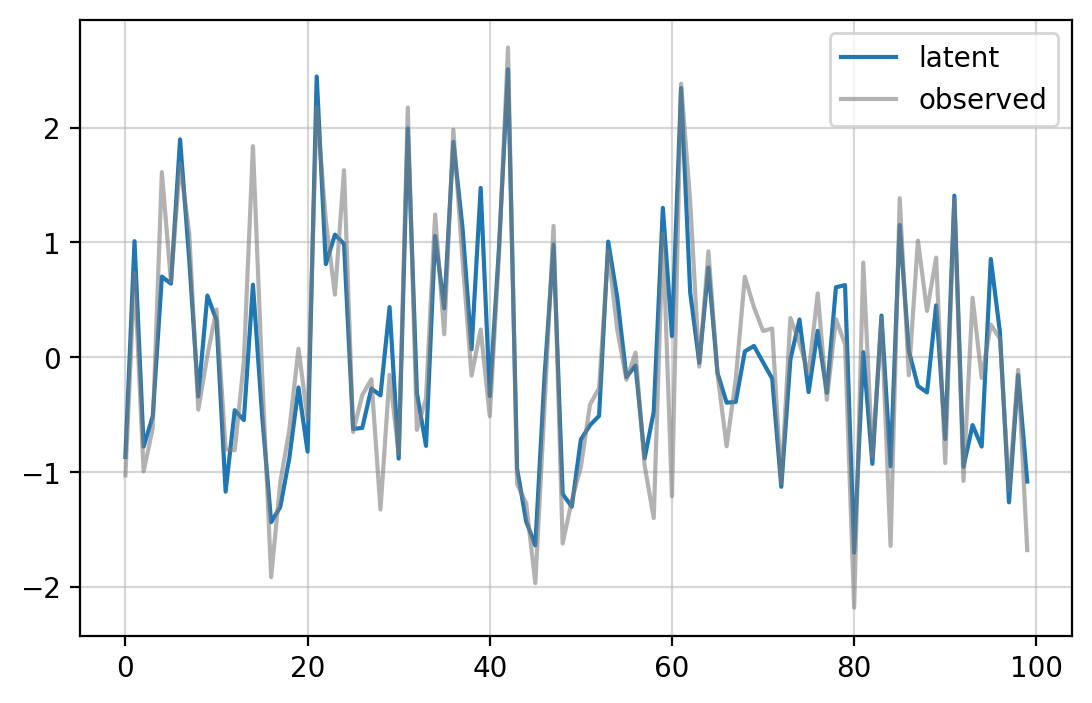

In [267]:
plt.plot(simulation.x, label="latent")
plt.plot(simulation.y, label="observed", c="tab:gray", alpha=0.6)
plt.legend()
plt.grid(alpha=0.5)

In [268]:
class BootstrapProposal:
    def __init__(self, params: nmgsm.ModelParameters):
        self.params = params
    
    def sample(self, key, particle_cond, step, _):
        phi = self.params.phi
        q = self.params.q
        last_val = particle_cond[step]
        
        eps = jax.random.normal(key)
        value = phi * last_val + jnp.sqrt(q) * eps
        return value
    
    def logpdf(self, x, particles, step):
        phi = self.params.phi
        q = self.params.q
        last_ix = step
        last_sample = particles[last_ix]
        
        dist_norm = distrax.Normal(loc=last_sample * phi, scale=jnp.sqrt(q))
        return dist_norm.log_prob(x)
    
    
class Target:
    def __init__(self, params: nmgsm.ModelParameters):
        self.params = params
    
    def logpdf(self, particles, step, obs):
        particles = particles.squeeze()
        indv = jnp.ones_like(obs).cumsum() <= step + 1
        lprobs = nmgsm.log_joint(particles, obs, self.params)
        log_likelihood = jnp.einsum("n,n->", lprobs, indv)
        return log_likelihood

In [288]:
num_particles = 35
dim_particle = 1

proposal = BootstrapProposal(params)
target = Target(params)


state_init = smc._init_state(num_particles, num_steps, dim_particle)
jax.tree_map(jnp.shape, state_init)

State(particles=(35, 100, 1), log_weights=(35,), step=())

In [289]:
particles_init = jax.random.normal(key_filter, (num_particles, 1))
state_init = state_init.replace(
     particles=state_init.particles.at[:, 0, :].set(particles_init)
)

In [290]:
keys_filter = jax.random.split(key_filter, num_steps)

def step(state, key):
    state_new = smc.step_and_update(key, state, simulation.y, proposal, target)
    return state_new, state_new.log_weights

In [291]:
state, logw_hist = jax.lax.scan(step, state_init, keys_filter)

In [292]:
jax.nn.logsumexp(logw_hist[0], b=1/num_particles)

DeviceArray(-1.2461538, dtype=float32)

In [294]:
mll_est = jax.nn.logsumexp(logw_hist, b=1/num_particles, axis=1)
mll_true = nmgsm.log_joint(simulation.x, simulation.y, params)

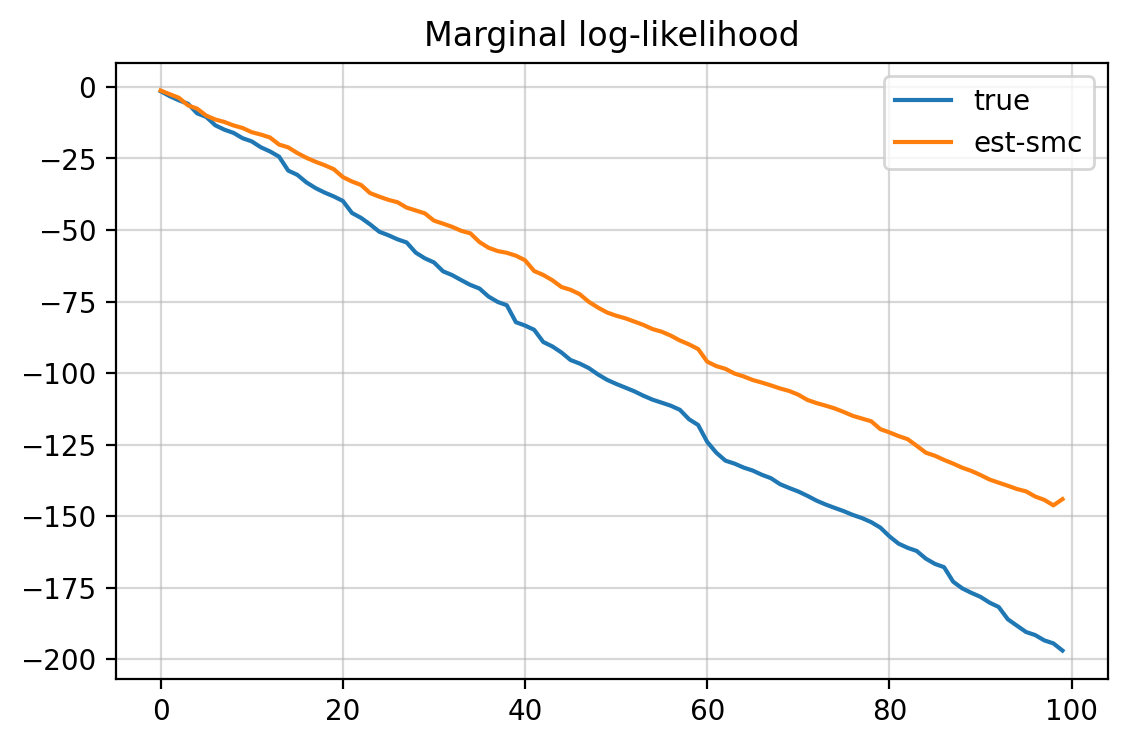

In [295]:
plt.plot(mll_true.cumsum(), label="true")
plt.plot(mll_est.cumsum(), label="est-smc")
plt.legend()
plt.title("Marginal log-likelihood")
plt.grid(alpha=0.5)

## Comparing posterior mean with ground truth

In [296]:
weights = jnp.exp(state.log_weights - jax.nn.logsumexp(state.log_weights, axis=-1, keepdims=True))
xhat = jnp.einsum("s,st...->t", weights, state.particles)

Text(0.5, 0.98, 'Posterior estimation comparisson')

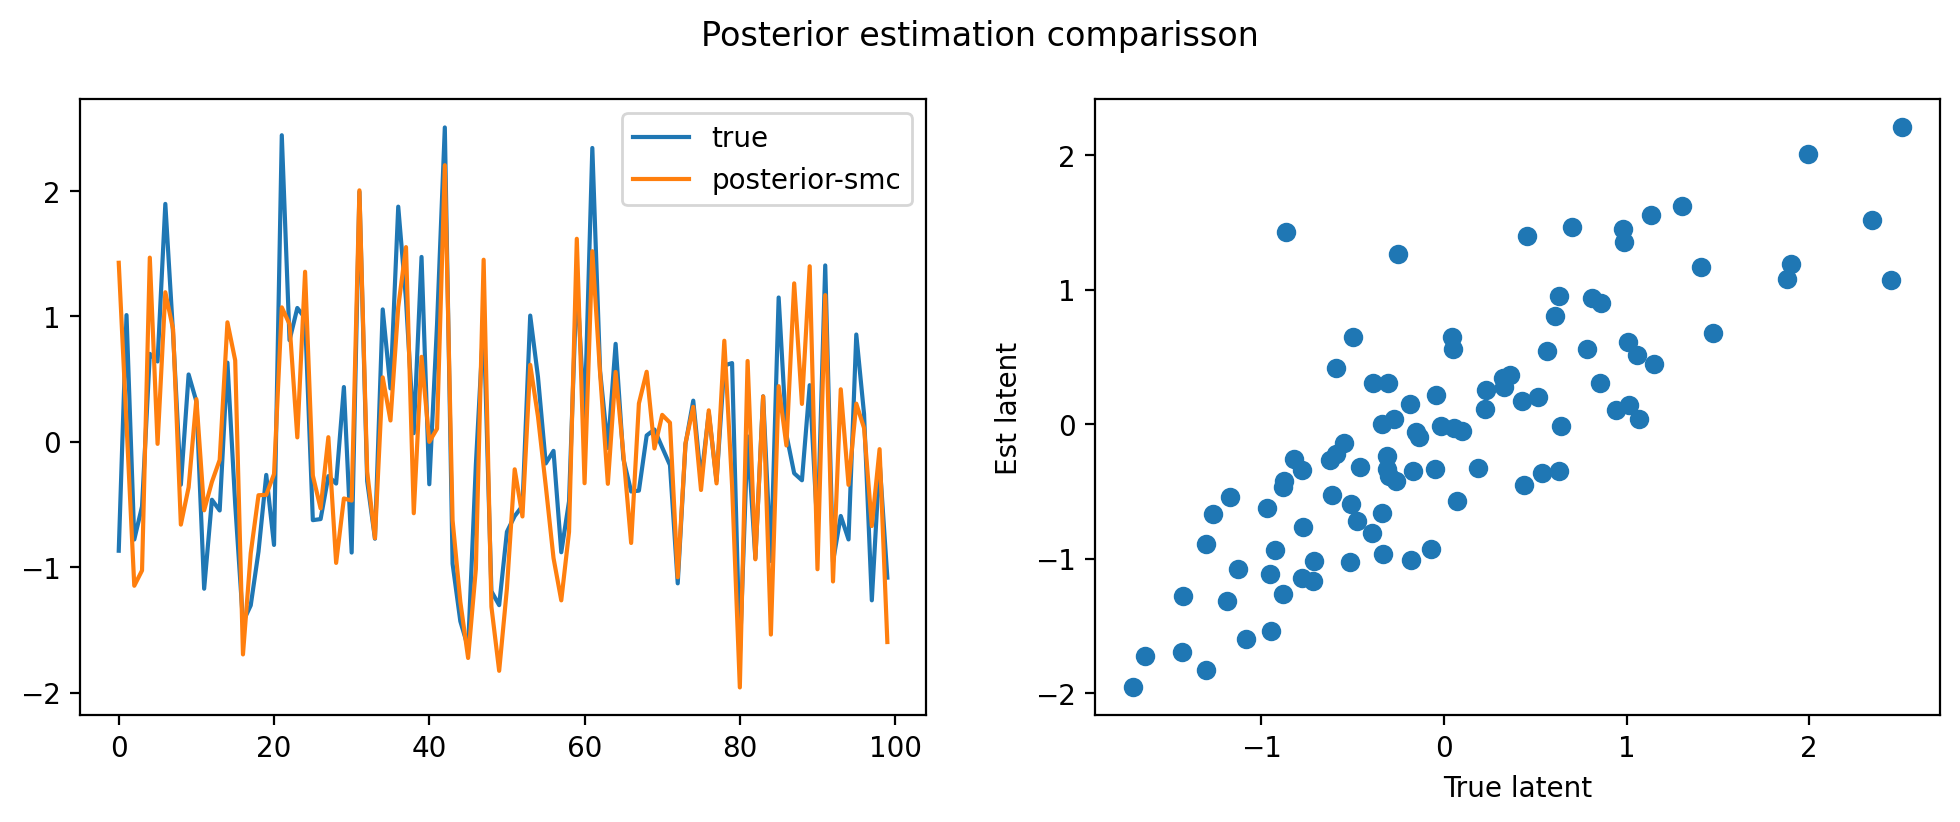

In [297]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(simulation.x, label="true")
ax[0].plot(xhat, label="posterior-smc")
ax[0].legend()

ax[1].scatter(simulation.x, xhat)
ax[1].set_xlabel("True latent")
ax[1].set_ylabel("Est latent")

plt.suptitle("Posterior estimation comparisson")